<a href="https://colab.research.google.com/github/zuzannazak/Tangles/blob/main/Tangle_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tangles theoretical intro

##Definitions

Traditional clustering identifies groups of objects that share
certain qualities. Tangles do the converse: they identify
groups of qualities that often occur together. They can
thereby identify and discover types: of behaviour, views,
abilities, dispositions.



*   (potential) features s of (elements v of) V (aka separations)
   *    The elements of S are called potential features of (the elements of) V, those of S~ are their features. An element of V has a feature A if it lies in A.
*   specifications →s , ←s of such s
   *   A subset of S~ is a specification of S if for every s ∈ S it contains either →s or ←s but not both. The elements of S are called potential features of (the elements of) V, those of S~ are their features. An element of V has a feature A if it lies in A.
   *   types (or typical specifications of S) 
      *   A subset of S~ is a specification of S if for every s ∈ S it contains either →s or ←s but not both.
   *   consistency of specifications
     *   A subset of S~ is inconsistent if it contains three features →r, →s, →t such that no element of V has them al
*   tangles
   *   Every Fn-tangle of S contains all the features ←s for which →s has fewer than n elements, because it cannot contain {→s } ∈ Fn as a subset.
*   star
   *   A set of features is a star if their inverses are disjoint subsets of V. 
*   universe of features
   *   We shall be particularly interested in sets S such that S~ contains, for any given →r ,→s ∈ S~, also the features →r ∨ →s and →r ∧ →s . If S has this property, then S~ will, in fact, contain all Boolean expressions of features it contains already - combinations of features built from others by using the symbols ∨ and ∧ and taking inverses. We then call S~ a universe of features.
*   submodularity
   *   S and S~ are submodular if for any two features →r ,→s ∈ S~ at least one of →r ∨ →s and →r ∧ →s is also in S~.



#Tangles example - Absenteeism at work Data Set
From https://archive.ics.uci.edu/ml/datasets/Absenteeism+at+work

##Imports and data preparation


In [1]:
pip install openpyxl==3.0.0

     |████████████████████████████████| 172 kB 5.2 MB/s 
  Created wheel for openpyxl: filename=openpyxl-3.0.0-py2.py3-none-any.whl size=241207 sha256=cb6d2a41d7cf66b6e3550e0a4b1fe956982f80b4f9a6569a913a45d2fa5ae755
  Stored in directory: /root/.cache/pip/wheels/c7/64/ff/ce98f6e1d2701ae8e216c875da62feed2839ac8a3cae0ab8af
Successfully built openpyxl
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 3.0.9
    Uninstalling openpyxl-3.0.9:
      Successfully uninstalled openpyxl-3.0.9


In [2]:
pip install xlrd==1.2.0

     |████████████████████████████████| 103 kB 5.3 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [3]:
pip install anytree

     |████████████████████████████████| 41 kB 280 kB/s 


In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

import pandas as pd
import numpy as np
import openpyxl
from anytree import AnyNode, Node, RenderTree, find, PostOrderIter, PreOrderIter, find_by_attr

In [46]:
df_original = pd.read_excel("https://github.com/zuzannazak/Tangles/blob/main/Data_Absenteeism_at_work/Absenteeism_at_work.xls?raw=true")
df_original = df_original.reset_index()
df_original.head()


,index,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,0,11,26,7,3,1,289,36,13,33,239554,97,0,1,2,1,0,1,90,172,30,4
1,1,36,0,7,3,1,118,13,18,50,239554,97,1,1,1,1,0,0,98,178,31,0
2,2,3,23,7,4,1,179,51,18,38,239554,97,0,1,0,1,0,0,89,170,31,2
3,3,7,7,7,5,1,279,5,14,39,239554,97,0,1,2,1,1,0,68,168,24,4
4,4,11,23,7,5,1,289,36,13,33,239554,97,0,1,2,1,0,1,90,172,30,2


In [47]:
df_original = df_original.drop(['ID', 'Distance from Residence to Work', 'Transportation expense', 'Work load Average/day '], axis=1)

In [48]:
df_amended_for_tangles = pd.DataFrame()
df_amended_for_tangles["index"]=df_original["index"]

for columnName in df_original.iteritems():
  if columnName[0] == "index":
    print("this is the ID column")
  else:
    i=0
    original_column = columnName[0]
    arr = df_original[str(original_column)].to_numpy()
    unique_arr = np.unique(arr)
    while i < len(unique_arr):
      thiscolumnname = original_column + " - " + str(unique_arr[i])
      df_amended_for_tangles[thiscolumnname] = (np.where(df_original[original_column].values == i, "Yes", "No"))
      i=i+1


df_amended_for_tangles = df_amended_for_tangles.sample(frac=0.05, replace=False, random_state=1)
df_amended_for_tangles

this is the ID column


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


,index,Reason for absence - 0,Reason for absence - 1,Reason for absence - 2,Reason for absence - 3,Reason for absence - 4,Reason for absence - 5,Reason for absence - 6,Reason for absence - 7,Reason for absence - 8,Reason for absence - 9,Reason for absence - 10,Reason for absence - 11,Reason for absence - 12,Reason for absence - 13,Reason for absence - 14,Reason for absence - 15,Reason for absence - 16,Reason for absence - 17,Reason for absence - 18,Reason for absence - 19,Reason for absence - 21,Reason for absence - 22,Reason for absence - 23,Reason for absence - 24,Reason for absence - 25,Reason for absence - 26,Reason for absence - 27,Reason for absence - 28,Month of absence - 0,Month of absence - 1,Month of absence - 2,Month of absence - 3,Month of absence - 4,Month of absence - 5,Month of absence - 6,Month of absence - 7,Month of absence - 8,Month of absence - 9,Month of absence - 10,...,Height - 178,Height - 182,Height - 185,Height - 196,Body mass index - 19,Body mass index - 21,Body mass index - 22,Body mass index - 23,Body mass index - 24,Body mass index - 25,Body mass index - 27,Body mass index - 28,Body mass index - 29,Body mass index - 30,Body mass index - 31,Body mass index - 32,Body mass index - 33,Body mass index - 34,Body mass index - 35,Body mass index - 36,Body mass index - 38,Absenteeism time in hours - 0,Absenteeism time in hours - 1,Absenteeism time in hours - 2,Absenteeism time in hours - 3,Absenteeism time in hours - 4,Absenteeism time in hours - 5,Absenteeism time in hours - 7,Absenteeism time in hours - 8,Absenteeism time in hours - 16,Absenteeism time in hours - 24,Absenteeism time in hours - 32,Absenteeism time in hours - 40,Absenteeism time in hours - 48,Absenteeism time in hours - 56,Absenteeism time in hours - 64,Absenteeism time in hours - 80,Absenteeism time in hours - 104,Absenteeism time in hours - 112,Absenteeism time in hours - 120
681,681,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No
257,257,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,...,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
527,527,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,...,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No
637,637,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No
429,429,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No
350,350,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
412,412,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No
189,189,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
670,670,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,N

##Tangles


In [49]:
df = df_amended_for_tangles
object_identifier_column_name = "index"


questions_with_cost_df = pd.DataFrame(columns=['Question', 'Cost'])
for columnName in df.iteritems():
  qA = df.loc[df[str(columnName[0])] == "Yes"]
  qB = df.loc[df[str(columnName[0])] == "No"]

  qA = qA.reset_index(drop=True)
  qB = qB.reset_index(drop=True)


  sum_of_similarities = 0

  for i, row in qA.iterrows():
      for l, row in qB.iterrows():
        for k in range(df.shape[1]):
          if qB.iat[l,k] == qA.iat[i,k]: 
            sum_of_similarities = sum_of_similarities +1


  number_of_pairs_between_sets = qA.shape[0]*qB.shape[0]
  if number_of_pairs_between_sets == 0:
    number_of_pairs_between_sets = 0.0000001
  normalized_func_cost = sum_of_similarities/number_of_pairs_between_sets

  questions_with_cost_df = pd.concat([questions_with_cost_df, pd.DataFrame({'Question': [str(columnName[0])],
                    'Cost' : [normalized_func_cost]})], ignore_index = True, axis = 0)

  sum_of_similarities = 0

questions_with_cost_df = questions_with_cost_df[questions_with_cost_df["Question"] != object_identifier_column_name]
questions_with_cost_df = questions_with_cost_df.sort_values(by=['Cost'])
questions_with_cost_df = questions_with_cost_df.reset_index(drop=True)
questions_with_cost_df

,Question,Cost
0,Hit target - 97,0.000000
1,Weight - 68,0.000000
2,Weight - 69,0.000000
3,Weight - 70,0.000000
4,Weight - 73,0.000000
...,...,...
195,Month of absence - 4,187.780303
196,Reason for absence - 10,188.083333
197,Service time - 24,188.416667
198,Absenteeism time in hours - 1,188.657143


In [50]:
def list_of_people_to_string(df):
    list_of_people = ""
    for row in df[object_identifier_column_name]:
      list_of_people = list_of_people + str(row) + ", "
    return list_of_people

In [51]:
def giveChildrenByRootId(root_of_the_tree, parent_name):
  parent=find_by_attr(root_of_the_tree, parent_name)
  child_list=[]

  questions_with_cost_df1 = parent.questions
  if parent.level <= (len(questions_with_cost_df1)):
      people_list = parent.people_list
      column_applicable =  questions_with_cost_df1["Question"].iat[parent.level]

      left = people_list.loc[people_list[str(column_applicable)] == "Yes"]
      right = people_list.loc[people_list[str(column_applicable)] == "No"]

      childlevel=parent.level+1

      if len(left) != 0 and len(people_list)>1 and parent.level<len(questions_with_cost_df1)-1:
        id_left = questions_with_cost_df1["Question"].iat[parent.level] + ": " + list_of_people_to_string(left)
        childleft = Node(id = id_left, name = id_left, people_list=left, questions=questions_with_cost_df1, level = childlevel, parent=find_by_attr(root_of_the_tree, parent_name))
        child_list.append(childleft)

      if len(right) != 0 and len(people_list)>1 and parent.level<len(questions_with_cost_df1)-1:
        id_right = questions_with_cost_df1["Question"].iat[parent.level] + ": " + list_of_people_to_string(right)
        childright = Node(id=id_right, name=id_right, people_list=right, questions=questions_with_cost_df1, level = childlevel, parent=find_by_attr(root_of_the_tree, parent_name))
        child_list.append(childright)
    
 # for pre, fill, node in RenderTree(root_of_the_tree):
  #  print("%s%s" % (pre, node.name))
    
  return "done!"

In [52]:
def giveChildrenByRootId(root_of_the_tree, parent_name):
  parent=find_by_attr(root_of_the_tree, parent_name)
  child_list=[]

  questions_with_cost_df1 = parent.questions
  if parent.level <= (len(questions_with_cost_df1)):
      people_list = parent.people_list
      
      childlevel=parent.level+1

      column_applicable =  questions_with_cost_df1["Question"].iat[childlevel]

      left = people_list.loc[people_list[str(column_applicable)] == "Yes"]
      right = people_list.loc[people_list[str(column_applicable)] == "No"]


      if len(left) != 0 and len(people_list)>1 and childlevel<len(questions_with_cost_df1):
        id_left = questions_with_cost_df1["Question"].iat[childlevel] + ": " + list_of_people_to_string(left)
        childleft = Node(id = id_left, name = id_left, people_list=left, questions=questions_with_cost_df1, level = childlevel, parent=find_by_attr(root_of_the_tree, parent_name))
        child_list.append(childleft)

      if len(right) != 0 and len(people_list)>1 and childlevel<len(questions_with_cost_df1):
        id_right = questions_with_cost_df1["Question"].iat[childlevel] + ": " + list_of_people_to_string(right)
        childright = Node(id=id_right, name=id_right, people_list=right, questions=questions_with_cost_df1, level = childlevel, parent=find_by_attr(root_of_the_tree, parent_name))
        child_list.append(childright)
    
 # for pre, fill, node in RenderTree(root_of_the_tree):
  #  print("%s%s" % (pre, node.name))
    
  return "done!"

In [53]:
root = Node(name=list_of_people_to_string(df), people_list=df, questions=questions_with_cost_df, children=[], level=-1)

for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))

681, 257, 527, 637, 429, 350, 412, 189, 670, 411, 459, 104, 597, 707, 311, 8, 305, 518, 624, 719, 656, 47, 678, 19, 368, 675, 512, 181, 408, 704, 363, 333, 432, 69, 60, 366, 399, 


In [54]:
list_of_nodes_checked = []
list_of_nodes_to_check = [node.name for node in PreOrderIter(root)]

while len([node.name for node in PreOrderIter(root, filter_=lambda n: n.name not in list_of_nodes_checked)]) != 0:
  list_of_nodes_to_check = [node.name for node in PreOrderIter(root, filter_=lambda n: n.name not in list_of_nodes_checked)]
  try:
    giveChildrenByRootId(root, list_of_nodes_to_check[0])
  except Exception:
    pass
  list_of_nodes_checked.append(list_of_nodes_to_check[0])

In [55]:
for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))

681, 257, 527, 637, 429, 350, 412, 189, 670, 411, 459, 104, 597, 707, 311, 8, 305, 518, 624, 719, 656, 47, 678, 19, 368, 675, 512, 181, 408, 704, 363, 333, 432, 69, 60, 366, 399, 
└── Hit target - 97: 681, 257, 527, 637, 429, 350, 412, 189, 670, 411, 459, 104, 597, 707, 311, 8, 305, 518, 624, 719, 656, 47, 678, 19, 368, 675, 512, 181, 408, 704, 363, 333, 432, 69, 60, 366, 399, 
    └── Weight - 68: 681, 257, 527, 637, 429, 350, 412, 189, 670, 411, 459, 104, 597, 707, 311, 8, 305, 518, 624, 719, 656, 47, 678, 19, 368, 675, 512, 181, 408, 704, 363, 333, 432, 69, 60, 366, 399, 
        └── Weight - 69: 681, 257, 527, 637, 429, 350, 412, 189, 670, 411, 459, 104, 597, 707, 311, 8, 305, 518, 624, 719, 656, 47, 678, 19, 368, 675, 512, 181, 408, 704, 363, 333, 432, 69, 60, 366, 399, 
            └── Weight - 70: 681, 257, 527, 637, 429, 350, 412, 189, 670, 411, 459, 104, 597, 707, 311, 8, 305, 518, 624, 719, 656, 47, 678, 19, 368, 675, 512, 181, 408, 704, 363, 333, 432, 69, 60, 366, 399, 
    

##k-means

In [62]:
pip install kneed

In [63]:
import matplotlib.pyplot as plt
   ...: from kneed import KneeLocator
   ...: from sklearn.datasets import make_blobs
   ...: from sklearn.cluster import KMeans
   ...: from sklearn.metrics import silhouette_score
   ...: from sklearn.preprocessing import StandardScaler

In [67]:
features, true_labels = make_blobs(
   ...:     n_samples=200,
   ...:     centers=3,
   ...:     cluster_std=2.75,
   ...:     random_state=42
   ...: )

In [65]:
scaler = StandardScaler()
   ...: scaled_features = scaler.fit_transform(features)

In [66]:
kmeans = KMeans(
   ...:     init="random",
   ...:     n_clusters=3,
   ...:     n_init=10,
   ...:     max_iter=300,
   ...:     random_state=42
   ...: )

In [68]:
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=3, random_state=42)

In [69]:
kmeans.inertia_# The lowest SSE value

74.57960106819854

In [70]:
# Final locations of the centroid
   ...: kmeans.cluster_centers_

array([[-0.25813925,  1.05589975],
       [-0.91941183, -1.18551732],
       [ 1.19539276,  0.13158148]])

In [71]:
# The number of iterations required to converge
   ...: kmeans.n_iter_

2

In [72]:
kmeans.labels_[:5]

array([2, 0, 1, 1, 1], dtype=int32)

In [73]:
kmeans_kwargs = {
   ...:     "init": "random",
   ...:     "n_init": 10,
   ...:     "max_iter": 300,
   ...:     "random_state": 42,
   ...: }
   ...:
   ...: # A list holds the SSE values for each k
   ...: sse = []
   ...: for k in range(1, 11):
   ...:     kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
   ...:     kmeans.fit(scaled_features)
   ...:     sse.append(kmeans.inertia_)

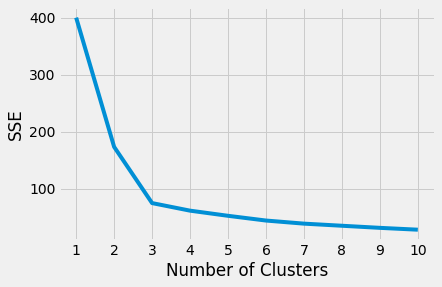

In [75]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

#Tangles example - fake yes/no questionnaire

In [ ]:
pip install openpyxl==3.0.0

In [ ]:
pip install anytree

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

import pandas as pd
import numpy as np
import openpyxl
from anytree import AnyNode, Node, RenderTree, find, PostOrderIter, PreOrderIter, find_by_attr


In [ ]:
#df = pd.read_excel("/content/drive/MyDrive/STUDIA/Doktorskie/Tangle/Tangles_example_fake_data.xlsx")
df = pd.read_excel("https://github.com/zuzannazak/Tangles/blob/main/Tangles_example_fake_data.xlsx?raw=true")
df.head()

,Person,Question 1,Question 2,Question 3,Question 4,Question 5,Question 6,Question 7,Question 8,Question 9,Question 10
0,A,Yes,Yes,No,No,No,No,Yes,No,No,Yes
1,B,Yes,Yes,No,Yes,Yes,No,No,Yes,Yes,Yes
2,C,Yes,Yes,No,No,Yes,No,Yes,Yes,No,Yes
3,D,Yes,Yes,No,Yes,No,No,No,No,Yes,Yes
4,E,Yes,Yes,No,No,Yes,No,No,Yes,Yes,Yes


In [ ]:
#calculating cost function for cuts - the mean over the similarities over all possible pairs of separated persons:

questions_with_cost_df = pd.DataFrame(columns=['Question', 'Cost'])
for columnName in df.iteritems():
  qA = df.loc[df[str(columnName[0])] == "Yes"]
  qB = df.loc[df[str(columnName[0])] == "No"]

  qA = qA.reset_index(drop=True)
  qB = qB.reset_index(drop=True)


  sum_of_similarities = 0

  for i, row in qA.iterrows():
      for l, row in qB.iterrows():
        for k in range(10):
          if qB.iat[l,k] == qA.iat[i,k]: 
            sum_of_similarities = sum_of_similarities +1
            #print(str(j) + ": rząd " + str(l) + ", pytanie " + str(k) + ": " + q1B.iat[l,k] + " i "+"rząd " + str(i) +", pytanie " + str(k) + ": " + q1A.iat[i,k])
            #print(sum_of_similarities)

  number_of_pairs_between_sets = qA.shape[0]*qB.shape[0]
  if number_of_pairs_between_sets == 0:
    number_of_pairs_between_sets = 0.0000001
  normalized_func_cost = sum_of_similarities/number_of_pairs_between_sets

  questions_with_cost_df = pd.concat([questions_with_cost_df, pd.DataFrame({'Question': [str(columnName[0])],
                    'Cost' : [normalized_func_cost]})], ignore_index = True, axis = 0)

  sum_of_similarities = 0

questions_with_cost_df = questions_with_cost_df[questions_with_cost_df["Question"] != "Person"]
questions_with_cost_df = questions_with_cost_df.sort_values(by=['Cost'])
questions_with_cost_df = questions_with_cost_df.reset_index(drop=True)
questions_with_cost_df
#why 0 when all of them are different, or all of them are the same?

,Question,Cost
0,Question 2,0.000000
1,Question 3,4.404762
2,Question 6,4.531746
3,Question 1,4.641667
4,Question 9,4.727273
5,Question 8,4.761905
6,Question 5,4.769841
7,Question 7,4.785714
8,Question 4,4.823077
9,Question 10,5.225000


In [ ]:
def list_of_people_to_string(df):
    list_of_people = ""
    for row in df["Person"]:
      list_of_people = list_of_people + str(row) + ", "
    return list_of_people

In [ ]:
def giveChildrenByRootId(root_of_the_tree, parent_name):
  parent=find_by_attr(root_of_the_tree, parent_name)
  child_list=[]

  questions_with_cost_df1 = parent.questions
  if parent.level <= (len(questions_with_cost_df1)):
      people_list = parent.people_list
      column_applicable =  questions_with_cost_df1["Question"].iat[parent.level]

      left = people_list.loc[people_list[str(column_applicable)] == "Yes"]
      right = people_list.loc[people_list[str(column_applicable)] == "No"]

      childlevel=parent.level+1

      if len(left) != 0 and len(people_list)>1 and parent.level<len(questions_with_cost_df1)-1:
        id_left = questions_with_cost_df1["Question"].iat[parent.level] + ": " + list_of_people_to_string(left)
        childleft = Node(id = id_left, name = id_left, people_list=left, questions=questions_with_cost_df1, level = childlevel, parent=find_by_attr(root_of_the_tree, parent_name))
        child_list.append(childleft)

      if len(right) != 0 and len(people_list)>1 and parent.level<len(questions_with_cost_df1)-1:
        id_right = questions_with_cost_df1["Question"].iat[parent.level] + ": " + list_of_people_to_string(right)
        childright = Node(id=id_right, name=id_right, people_list=right, questions=questions_with_cost_df1, level = childlevel, parent=find_by_attr(root_of_the_tree, parent_name))
        child_list.append(childright)
    
 # for pre, fill, node in RenderTree(root_of_the_tree):
  #  print("%s%s" % (pre, node.name))
    
  return "done!"

In [ ]:
def giveChildrenByRootId(root_of_the_tree, parent_name):
  parent=find_by_attr(root_of_the_tree, parent_name)
  child_list=[]

  questions_with_cost_df1 = parent.questions
  if parent.level <= (len(questions_with_cost_df1)):
      people_list = parent.people_list
      
      childlevel=parent.level+1

      column_applicable =  questions_with_cost_df1["Question"].iat[childlevel]

      left = people_list.loc[people_list[str(column_applicable)] == "Yes"]
      right = people_list.loc[people_list[str(column_applicable)] == "No"]


      if len(left) != 0 and len(people_list)>1 and childlevel<len(questions_with_cost_df1):
        id_left = questions_with_cost_df1["Question"].iat[childlevel] + ": " + list_of_people_to_string(left)
        childleft = Node(id = id_left, name = id_left, people_list=left, questions=questions_with_cost_df1, level = childlevel, parent=find_by_attr(root_of_the_tree, parent_name))
        child_list.append(childleft)

      if len(right) != 0 and len(people_list)>1 and childlevel<len(questions_with_cost_df1):
        id_right = questions_with_cost_df1["Question"].iat[childlevel] + ": " + list_of_people_to_string(right)
        childright = Node(id=id_right, name=id_right, people_list=right, questions=questions_with_cost_df1, level = childlevel, parent=find_by_attr(root_of_the_tree, parent_name))
        child_list.append(childright)
    
 # for pre, fill, node in RenderTree(root_of_the_tree):
  #  print("%s%s" % (pre, node.name))
    
  return "done!"

In [ ]:
root = Node(name=list_of_people_to_string(df), people_list=df, questions=questions_with_cost_df, children=[], level=-1)

for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))

A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, R, S, T, U, W, Y, Z, 


In [ ]:
list_of_nodes_checked = []
list_of_nodes_to_check = [node.name for node in PreOrderIter(root)]

while len([node.name for node in PreOrderIter(root, filter_=lambda n: n.name not in list_of_nodes_checked)]) != 0:
  list_of_nodes_to_check = [node.name for node in PreOrderIter(root, filter_=lambda n: n.name not in list_of_nodes_checked)]
  try:
    giveChildrenByRootId(root, list_of_nodes_to_check[0])
  except Exception:
    pass
  list_of_nodes_checked.append(list_of_nodes_to_check[0])

  



In [ ]:
for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))

A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, R, S, T, U, W, Y, Z, 
└── Question 2: A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, R, S, T, U, W, Y, Z, 
    ├── Question 3: W, Z, 
    │   ├── Question 6: W, 
    │   └── Question 6: Z, 
    └── Question 3: A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, R, S, T, U, Y, 
        ├── Question 6: F, G, H, I, J, N, P, S, 
        │   ├── Question 1: S, 
        │   └── Question 1: F, G, H, I, J, N, P, 
        │       ├── Question 9: G, I, J, N, 
        │       │   ├── Question 8: G, J, N, 
        │       │   │   └── Question 5: G, J, N, 
        │       │   │       └── Question 7: G, J, N, 
        │       │   │           ├── Question 4: J, 
        │       │   │           └── Question 4: G, N, 
        │       │   │               └── Question 10: G, N, 
        │       │   └── Question 8: I, 
        │       └── Question 9: F, H, P, 
        │           ├── Question 8: H, P, 
        │           │   └── Question 5: H, P, 
        │   

In [ ]:
#dane klasyfikacyjne i spróbować na nich stworzyć drzewo (k-średnich itp), porównać wyniki

##Naive table search algorythm
**Input:** The separation system S, enumerated as s1, . . . , sn; oracle access to F.

**Output:** For every i ≤ n a list Ti of all F-tangles of {s1, . . . , si}.